In [1]:
import tensorflow as tf 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers import BatchNormalization, concatenate
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
data = pd.read_csv("Train_data.csv")
data['img'] = data['img'].apply(lambda x : x[2:])
data['label'] = data['label'].astype('category')


data['steer'] = data['steer'].apply(lambda x : np.interp(x, [-65536, 65536], [-1, 1]))
data = data[data['label'] != 2]

train_df, val_df = train_test_split(data, test_size=0.33, random_state=42)

image_datagen = ImageDataGenerator(rescale=1./255)

train_imgs = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='C:/Users/Mohamed Ali/Documents/Semester_6/Artificial_Intelligence/Project/Trackmania_Self_Driving_AI_env',
    x_col='img',
    y_col=['label', 'steer'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='multi_output',
    validate_filenames=False
)
val_imgs = image_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='C:/Users/Mohamed Ali/Documents/Semester_6/Artificial_Intelligence/Project/Trackmania_Self_Driving_AI_env',
    x_col='img',
    y_col=['label', 'steer'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='multi_output',
    validate_filenames=False
)
data.head()

Found 32563 non-validated image filenames.
Found 16039 non-validated image filenames.


,img,left_15,left_30,left_45,left_60,left_75,right_15,right_30,right_45,right_60,right_75,speed,label,steer
1,img_data/img_A01_arian_10.jpg,255,277,201,126,82,131,277,196,126,64,0,0,0.152100
2,img_data/img_A01_arian_20.jpg,255,277,201,126,82,131,277,196,126,64,0,0,0.152100
3,img_data/img_A01_arian_30.jpg,255,10000,201,126,84,131,113,190,126,64,1,0,0.152100
4,img_data/img_A01_arian_40.jpg,257,291,198,126,84,123,113,197,126,64,1,0,0.168411
5,img_data/img_A01_arian_50.jpg,258,280,198,126,84,125,114,193,126,64,2,0,0.168411


In [2]:
input_img = Input(shape=(224, 224, 3), name='img_input')
### 1st layer
layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(layer_1)

layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(layer_2)

layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

mid_1 = concatenate([layer_1, layer_2, layer_3], axis = 3)
merged = Dropout(0.5)(mid_1)

In [3]:
flat_1 = Flatten()(merged)

classification_output = Dense(1, activation='sigmoid', name='classification_output')(flat_1)
Dense_1 = Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(flat_1)
linear_output = Dense(1, activation='linear', name='linear_output')(Dense_1)

model = Model(inputs=[input_img], outputs=[classification_output, linear_output])


In [4]:
model.compile(optimizer='adam', loss={'classification_output': 'binary_crossentropy', 'linear_output': 'mse'}, metrics=['accuracy'])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                             

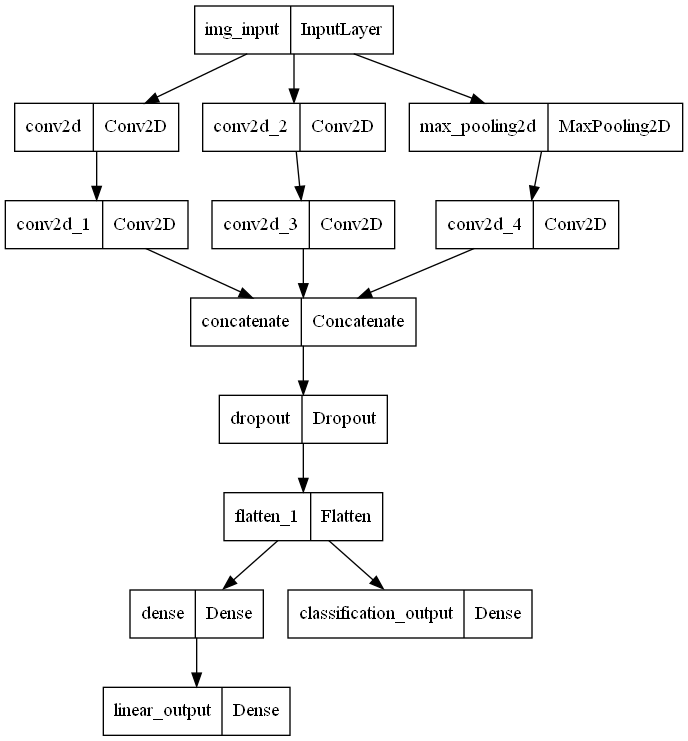

In [11]:
tf.keras.utils.plot_model(model)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('inception_model.h5', monitor='val_accuracy', save_best_only=True, save_freq="epoch")

In [13]:
model.fit(train_imgs,
          epochs=50,
          batch_size=32,
          validation_data=val_imgs,
          callbacks=[early_stop, checkpoint])

Epoch 1/50
1216/1216 [==============================] - 2788s 2s/step - loss: 28.8937 - classification_output_loss: 0.3694 - linear_output_loss: 28.5243 - classification_output_accuracy: 0.9873 - linear_output_accuracy: 0.3624 - val_loss: 0.4392 - val_classification_output_loss: 0.2716 - val_linear_output_loss: 0.1676 - val_classification_output_accuracy: 0.9933 - val_linear_output_accuracy: 0.4031
Epoch 2/50
1216/1216 [==============================] - 2808s 2s/step - loss: 0.3077 - classification_output_loss: 0.1540 - linear_output_loss: 0.1538 - classification_output_accuracy: 0.9943 - linear_output_accuracy: 0.4112 - val_loss: 0.3677 - val_classification_output_loss: 0.2519 - val_linear_output_loss: 0.1158 - val_classification_output_accuracy: 0.9942 - val_linear_output_accuracy: 0.4314
Epoch 3/50
1216/1216 [==============================] - 3045s 3s/step - loss: 0.2442 - classification_output_loss: 0.1364 - linear_output_loss: 0.1078 - classification_output_accuracy: 0.9964 - line

In [17]:
model.save_weights('./model_weights.h5')

In [4]:
model_1_input_img = Input(shape=(224, 224, 3), name='img_input')
### 1st layer
model_1_layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(model_1_input_img)
model_1_layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(model_1_layer_1)

model_1_layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(model_1_input_img)
model_1_layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(model_1_layer_2)

model_1_layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(model_1_input_img)
model_1_layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(model_1_layer_3)

model_1_mid_1 = concatenate([model_1_layer_1, model_1_layer_2, model_1_layer_3], axis = 3)
model_1_merged = Dropout(0.5)(model_1_mid_1)

In [18]:
model_1_flat_1 = Flatten()(model_1_merged)

model_1_classification_output = Dense(1, activation='sigmoid', name='classification_output')(model_1_flat_1)
model_1_Dense_1 = Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(model_1_flat_1)
model_1_Dense_2 = Dense(1, activation='tanh')(model_1_Dense_1)
model_1_dropout = Dropout(0.2)(model_1_Dense_2)
model_1_linear_output = Dense(1, activation='linear', name='linear_output')(model_1_dropout)

model_1 = Model(inputs=[model_1_input_img], outputs=[model_1_classification_output, model_1_linear_output])

In [19]:
model_1.compile(optimizer='adam', loss={'classification_output': 'binary_crossentropy', 'linear_output': 'mse'}, metrics=['accuracy'])

In [20]:
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                           

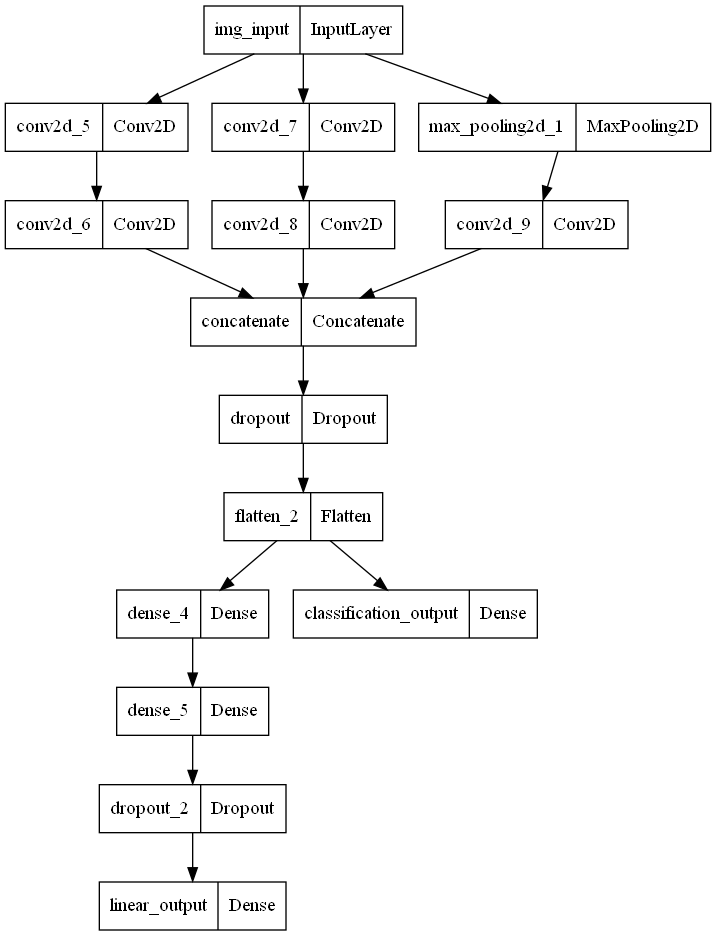

In [22]:
tf.keras.utils.plot_model(model_1, to_file="model_1.png")

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop_1 = EarlyStopping(monitor='val_linear_output_accuarcy', patience=3, verbose=1)
checkpoint_1 = ModelCheckpoint('inception_model', monitor='val_loss', save_best_only=True, save_freq="epoch", verbose=1)

In [25]:
model_1.fit(train_imgs,
          epochs=50,
          batch_size=32,
          validation_data=val_imgs,
          callbacks=[early_stop_1, checkpoint_1])

Epoch 1/50
1216/1216 [==============================] - 2730s 2s/step - loss: 0.1177 - classification_output_loss: 0.0132 - linear_output_loss: 0.1045 - classification_output_accuracy: 0.9982 - linear_output_accuracy: 0.4500 - val_loss: 0.0739 - val_classification_output_loss: 0.0169 - val_linear_output_loss: 0.0570 - val_classification_output_accuracy: 0.9987 - val_linear_output_accuracy: 0.4622
Epoch 2/50
1216/1216 [==============================] - 2729s 2s/step - loss: 0.0995 - classification_output_loss: 0.0104 - linear_output_loss: 0.0891 - classification_output_accuracy: 0.9988 - linear_output_accuracy: 0.4557 - val_loss: 0.0750 - val_classification_output_loss: 0.0175 - val_linear_output_loss: 0.0575 - val_classification_output_accuracy: 0.9978 - val_linear_output_accuracy: 0.4619
Epoch 3/50
1216/1216 [==============================] - 2727s 2s/step - loss: 0.0868 - classification_output_loss: 0.0053 - linear_output_loss: 0.0815 - classification_output_accuracy: 0.9992 - linear

KeyboardInterrupt: 

In [26]:
model_1.evaluate(val_imgs)

304/304 [==============================] - 82s 269ms/step - loss: 0.0531 - classification_output_loss: 0.0175 - linear_output_loss: 0.0356 - classification_output_accuracy: 0.9971 - linear_output_accuracy: 0.4729


[0.05312800407409668,
 0.017504272982478142,
 0.035623736679553986,
 0.997119665145874,
 0.47289374470710754]

In [27]:
model_1.save_weights('./checkpoints/model_1_weights.h5')

In [5]:
model_2_input_img = Input(shape=(224, 224, 3), name='img_input')
### 1st layer
model_2_layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(model_2_input_img)
model_2_layer_1 = Conv2D(10, (3,3), padding='same', activation='relu')(model_2_layer_1)
model_2_layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(model_2_input_img)
model_2_layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(model_2_layer_2)
model_2_layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(model_2_input_img)
model_2_layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(model_2_layer_3)
model_2_mid_1 = concatenate([model_2_layer_1, model_2_layer_2, model_2_layer_3], axis = 3)
model_2_merged = Dropout(0.5)(model_2_mid_1)

In [23]:
model_2_flat_1 = Flatten()(model_2_merged)

model_2_classification_output = Dense(1, activation='sigmoid', name='classification_output')(model_2_flat_1)
model_2_Dense_1 = Dense(16, activation='relu')(model_2_flat_1)
model_2_Dense_2 = Dense(8, activation='relu')(model_2_Dense_1)
model_2_Dense_3 = Dense(4, activation='relu')(model_2_Dense_2)
model_2_dropout = Dropout(0.25)(model_2_Dense_3)
model_2_linear_output = Dense(1, activation='tanh', name='linear_output')(model_2_dropout)

model_2 = Model(inputs=[model_2_input_img], outputs=[model_2_classification_output, model_2_linear_output])

In [24]:
model_2.compile(optimizer='adam', loss={'classification_output': 'binary_crossentropy', 'linear_output': 'mse'}, metrics=['accuracy'])

In [25]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 224, 224, 10  40          ['img_input[0][0]']              
                                )                                                           

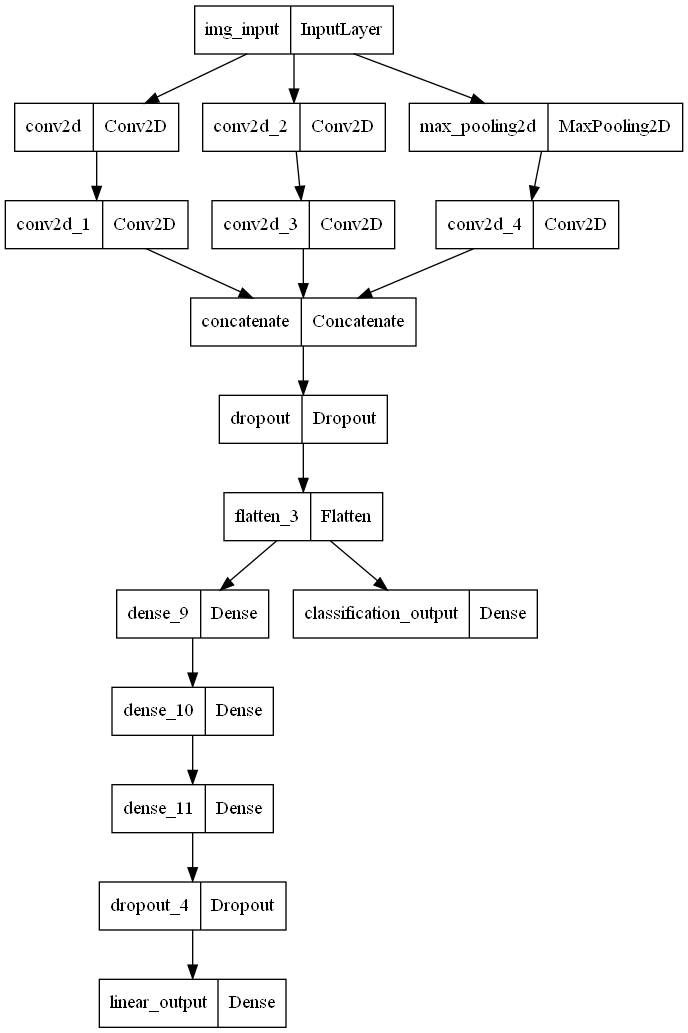

In [26]:
tf.keras.utils.plot_model(model_2, to_file="model_2.png")

In [27]:
early_stop_2 = EarlyStopping(monitor='val_linear_output_accuracy', patience=3, verbose=1)
checkpoint_2 = ModelCheckpoint('inception_model', monitor='val_loss', save_best_only=False, save_freq="epoch", verbose=1)

In [28]:
history_2 = model_2.fit(train_imgs,
          epochs=30,
          batch_size=32,
          validation_data=val_imgs,
          callbacks=[early_stop_2, checkpoint_2])

Epoch 1/30
1018/1018 [==============================] - ETA: 0s - loss: 0.2101 - classification_output_loss: 0.0306 - linear_output_loss: 0.1794 - classification_output_accuracy: 0.9945 - linear_output_accuracy: 0.4018
Epoch 1: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2334s 2s/step - loss: 0.2101 - classification_output_loss: 0.0306 - linear_output_loss: 0.1794 - classification_output_accuracy: 0.9945 - linear_output_accuracy: 0.4018 - val_loss: 0.0905 - val_classification_output_loss: 0.0119 - val_linear_output_loss: 0.0786 - val_classification_output_accuracy: 0.9981 - val_linear_output_accuracy: 0.4503
Epoch 2/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0999 - classification_output_loss: 0.0081 - linear_output_loss: 0.0918 - classification_output_accuracy: 0.9984 - linear_output_accuracy: 0.4419
Epoch 2: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2304s 2s/step - loss: 0.0999 - classification_output_loss: 0.0081 - linear_output_loss: 0.0918 - classification_output_accuracy: 0.9984 - linear_output_accuracy: 0.4419 - val_loss: 0.0557 - val_classification_output_loss: 0.0089 - val_linear_output_loss: 0.0467 - val_classification_output_accuracy: 0.9983 - val_linear_output_accuracy: 0.4646
Epoch 3/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0755 - classification_output_loss: 0.0059 - linear_output_loss: 0.0696 - classification_output_accuracy: 0.9990 - linear_output_accuracy: 0.4512
Epoch 3: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2298s 2s/step - loss: 0.0755 - classification_output_loss: 0.0059 - linear_output_loss: 0.0696 - classification_output_accuracy: 0.9990 - linear_output_accuracy: 0.4512 - val_loss: 0.0548 - val_classification_output_loss: 0.0187 - val_linear_output_loss: 0.0361 - val_classification_output_accuracy: 0.9977 - val_linear_output_accuracy: 0.4701
Epoch 4/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0669 - classification_output_loss: 0.0038 - linear_output_loss: 0.0632 - classification_output_accuracy: 0.9993 - linear_output_accuracy: 0.4525
Epoch 4: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2221s 2s/step - loss: 0.0669 - classification_output_loss: 0.0038 - linear_output_loss: 0.0632 - classification_output_accuracy: 0.9993 - linear_output_accuracy: 0.4525 - val_loss: 0.0518 - val_classification_output_loss: 0.0155 - val_linear_output_loss: 0.0363 - val_classification_output_accuracy: 0.9979 - val_linear_output_accuracy: 0.4697
Epoch 5/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0647 - classification_output_loss: 0.0043 - linear_output_loss: 0.0604 - classification_output_accuracy: 0.9991 - linear_output_accuracy: 0.4530
Epoch 5: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2064s 2s/step - loss: 0.0647 - classification_output_loss: 0.0043 - linear_output_loss: 0.0604 - classification_output_accuracy: 0.9991 - linear_output_accuracy: 0.4530 - val_loss: 0.0569 - val_classification_output_loss: 0.0197 - val_linear_output_loss: 0.0372 - val_classification_output_accuracy: 0.9975 - val_linear_output_accuracy: 0.4691
Epoch 6/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0602 - classification_output_loss: 0.0032 - linear_output_loss: 0.0570 - classification_output_accuracy: 0.9995 - linear_output_accuracy: 0.4544
Epoch 6: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2295s 2s/step - loss: 0.0602 - classification_output_loss: 0.0032 - linear_output_loss: 0.0570 - classification_output_accuracy: 0.9995 - linear_output_accuracy: 0.4544 - val_loss: 0.0522 - val_classification_output_loss: 0.0196 - val_linear_output_loss: 0.0326 - val_classification_output_accuracy: 0.9978 - val_linear_output_accuracy: 0.4719
Epoch 7/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0613 - classification_output_loss: 0.0033 - linear_output_loss: 0.0580 - classification_output_accuracy: 0.9995 - linear_output_accuracy: 0.4525
Epoch 7: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2241s 2s/step - loss: 0.0613 - classification_output_loss: 0.0033 - linear_output_loss: 0.0580 - classification_output_accuracy: 0.9995 - linear_output_accuracy: 0.4525 - val_loss: 0.0532 - val_classification_output_loss: 0.0225 - val_linear_output_loss: 0.0307 - val_classification_output_accuracy: 0.9976 - val_linear_output_accuracy: 0.4718
Epoch 8/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0579 - classification_output_loss: 0.0025 - linear_output_loss: 0.0554 - classification_output_accuracy: 0.9997 - linear_output_accuracy: 0.4541
Epoch 8: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2318s 2s/step - loss: 0.0579 - classification_output_loss: 0.0025 - linear_output_loss: 0.0554 - classification_output_accuracy: 0.9997 - linear_output_accuracy: 0.4541 - val_loss: 0.0592 - val_classification_output_loss: 0.0227 - val_linear_output_loss: 0.0365 - val_classification_output_accuracy: 0.9974 - val_linear_output_accuracy: 0.4680
Epoch 9/30
1018/1018 [==============================] - ETA: 0s - loss: 0.0578 - classification_output_loss: 0.0029 - linear_output_loss: 0.0549 - classification_output_accuracy: 0.9996 - linear_output_accuracy: 0.4545
Epoch 9: saving model to inception_model


INFO:tensorflow:Assets written to: inception_model\assets


INFO:tensorflow:Assets written to: inception_model\assets


1018/1018 [==============================] - 2347s 2s/step - loss: 0.0578 - classification_output_loss: 0.0029 - linear_output_loss: 0.0549 - classification_output_accuracy: 0.9996 - linear_output_accuracy: 0.4545 - val_loss: 0.0622 - val_classification_output_loss: 0.0250 - val_linear_output_loss: 0.0372 - val_classification_output_accuracy: 0.9971 - val_linear_output_accuracy: 0.4702
Epoch 9: early stopping


In [29]:
model_2.evaluate(val_imgs)

502/502 [==============================] - 144s 286ms/step - loss: 0.0622 - classification_output_loss: 0.0250 - linear_output_loss: 0.0372 - classification_output_accuracy: 0.9971 - linear_output_accuracy: 0.4702


[0.062217485159635544,
 0.025026774033904076,
 0.03719069063663483,
 0.9971320033073425,
 0.47022882103919983]

In [30]:
model_2.save_weights('./checkpoints/model_2_weights.h5')